# Zillow Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

## Business Problem

A real estate investment firm is interested in knowing the top five best New Jersey zip codes to invest in based on return on investment (ROI) and risk.  

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    #print(non_dt_cols)
    #print(dt_cols)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04-01,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04-01,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04-01,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04-01,664400.0


In [10]:
#Select NJ data for analysis
melted_df[melted_df['State'] == 'NJ']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
57,60545,7030,Hoboken,NJ,New York,Hudson,58,1996-04-01,301600.0
73,61148,8701,Lakewood,NJ,New York,Ocean,74,1996-04-01,153800.0
158,61169,8753,Toms River,NJ,New York,Ocean,159,1996-04-01,123400.0
187,60518,7002,Bayonne,NJ,New York,Hudson,188,1996-04-01,145000.0
191,60639,7302,Jersey City,NJ,New York,Hudson,192,1996-04-01,137200.0
...,...,...,...,...,...,...,...,...,...
3901341,61046,8319,Estell Manor,NJ,Atlantic City,Atlantic,14470,2018-04-01,188800.0
3901383,60903,8006,Barnegat Light,NJ,New York,Ocean,14512,2018-04-01,795200.0
3901409,61054,8328,Franklin,NJ,Philadelphia,Gloucester,14538,2018-04-01,161300.0
3901504,61044,8317,Weymouth,NJ,Atlantic City,Atlantic,14633,2018-04-01,165000.0


In [49]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['RegionName'].unique()

array([7030, 8701, 8753, 7002, 7302, 7093, 8831, 7087, 7305, 8759, 7047,
       8873, 8527, 7728, 7055, 7003, 7306, 8021, 7601, 7470, 8054, 7083,
       8053, 7024, 8540, 8854, 8757, 8081, 7712, 7104, 8724, 7052, 8816,
       7960, 8817, 8234, 7726, 7036, 8861, 7753, 7307, 8094, 8902, 8012,
       8360, 7105, 8857, 8844, 8901, 8096, 8302, 8332, 8807, 7060, 8080,
       7666, 7202, 8618, 8723, 7740, 8820, 7731, 7109, 8016, 7840, 7032,
       8742, 8043, 8865, 7107, 8648, 7011, 7747, 7410, 8822, 8610, 7065,
       7110, 7054, 7208, 7050, 8087, 8330, 8046, 7103, 8075, 8003, 7042,
       8226, 8050, 8205, 8055, 8520, 7631, 7013, 8005, 7090, 7039, 7501,
       7920, 7701, 7026, 7106, 8755, 7010, 7748, 7675, 7719, 7424, 7860,
       7430, 7006, 8002, 8204, 8060, 8088, 7724, 8638, 8619, 8052, 7869,
       8037, 8859, 8876, 7076, 7621, 7016, 8109, 8731, 7644, 8879, 7040,
       8536, 7652, 8611, 7450, 7866, 7901, 8721, 7201, 7080, 7801, 7008,
       8028, 8057, 8108, 7071, 7095, 7203, 7871, 79

In [46]:
#Create Bergen County dataframe
bergen_df = melted_df[(melted_df['State'] == 'NJ') & (melted_df['CountyName'] == 'Bergen')]
bergen_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
832,60714,7601,Hackensack,NJ,New York,Bergen,833,1996-04-01,157500.0
947,60540,7024,Fort Lee,NJ,New York,Bergen,948,1996-04-01,260200.0
2343,60750,7666,Teaneck,NJ,New York,Bergen,2344,1996-04-01,170800.0
3203,60656,7410,Fair Lawn,NJ,New York,Bergen,3204,1996-04-01,180500.0
3953,60729,7631,Englewood,NJ,New York,Bergen,3954,1996-04-01,163300.0


In [47]:
#Create Passaic County dataframe
passaic_df = melted_df[(melted_df['State'] == 'NJ') & (melted_df['CountyName'] == 'Passaic')]
passaic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
622,60565,7055,Passaic,NJ,New York,Passaic,623,1996-04-01,133100.0
840,60688,7470,Wayne,NJ,New York,Passaic,841,1996-04-01,240400.0
3128,60527,7011,Clifton,NJ,New York,Passaic,3129,1996-04-01,147600.0
3968,60529,7013,Clifton,NJ,New York,Passaic,3969,1996-04-01,170800.0
4044,60694,7501,Paterson,NJ,New York,Passaic,4045,1996-04-01,105400.0


In [52]:
passaic_df.City.unique()

array(['Passaic', 'Wayne', 'Clifton', 'Paterson', 'Little Falls',
       'North Haledon', 'Hawthorne', 'West Milford', 'Ringwood',
       'Pompton Lakes', 'Totowa', 'Bloomingdale', 'Wanaque'], dtype=object)

<AxesSubplot:>

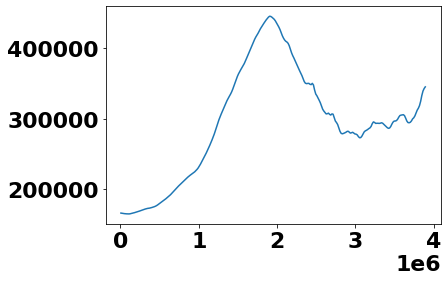

In [51]:
passaic_df.loc[passaic_df['City'] == 'North Haledon']['value'].plot()

<AxesSubplot:>

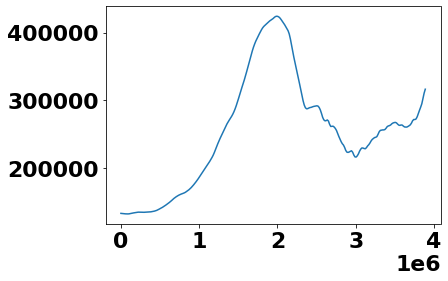

In [43]:
passaic_df.loc[passaic_df['RegionName'] == 7055]['value'].plot()

<AxesSubplot:xlabel='time,RegionName'>

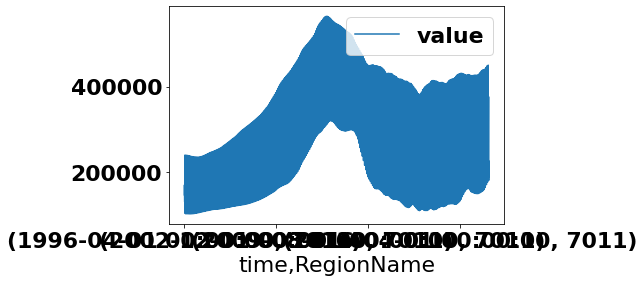

In [34]:
passaic_df.groupby(['time', 'RegionName']).aggregate({'value':'mean'}).plot()
#passaic_df['value'].plot()

<AxesSubplot:>

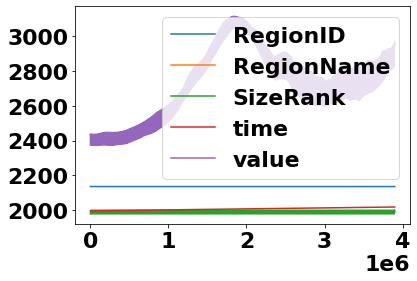

In [28]:
passaic_df.loc[passaic_df['City'] == 'Clifton'].plot() 

In [25]:
'Clifton' == True

False

In [14]:
#Check unique cities for Passaic County
passaic_df.City.unique()

array(['Passaic', 'Wayne', 'Clifton', 'Paterson', 'Little Falls',
       'North Haledon', 'Hawthorne', 'West Milford', 'Ringwood',
       'Pompton Lakes', 'Totowa', 'Bloomingdale', 'Wanaque'], dtype=object)

In [15]:
#Take the mean of each Passaic County value
passaic_df.groupby('time').aggregate({'value':'mean'})

,value
time,
1996-04-01,149352.0
1996-05-01,149192.0
1996-06-01,149036.0
1996-07-01,148872.0
1996-08-01,148736.0
...,...
2017-12-01,286644.0
2018-01-01,289556.0
2018-02-01,293160.0


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


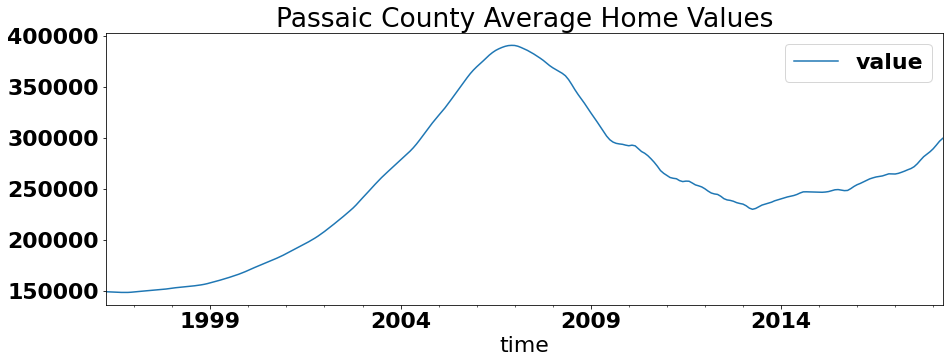

In [16]:
passaic_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Passaic County Average Home Values');

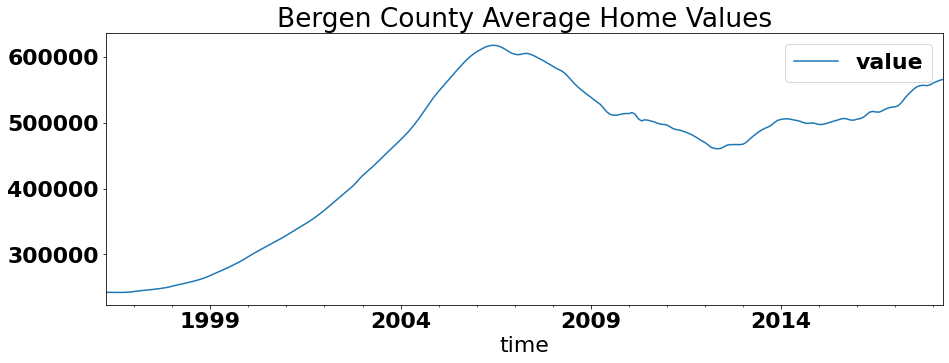

In [45]:
bergen_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Bergen County Average Home Values');

## ARIMA Modeling

## Interpreting Results